# [E-08] 카메라 스티커앱 만들기 첫걸음

openCV2, dlib을 사용하여 동영상 처리, 검출, 키포인트 추정, 추적, 카메라 원근의 기술을 익히고 사진을 인식하여 얼굴에 적절한 위치에 sticker를 붙혀주는 sticker app을 만들어본다. 이후 여러 실험을 통하여 문제점을 분석하여본다.

## 목차
### 00. import
### 01. Data 가져오기
### 02. 얼굴 검출 & 랜드마크 검출 하기
### 03. 스티커 적용 위치 확인하기
### 04. 스티커 적용하기
### 05. 문제점 찾아보기
### 06. 회고
### 07. 참고

## 00. import

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
import sys

## 01. Data 가져오기

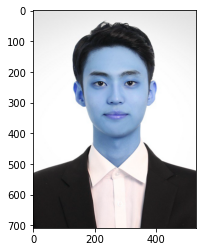

In [2]:
'''
Data를 loading하여 cv2를 사용하여 image를 불러온다.
'''

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/front.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

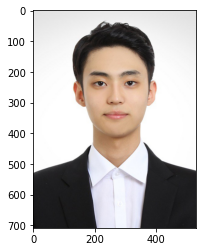

In [3]:
'''
opencv는 file을 bgr로 받아내기에 rgb로 바꾸어 출력해본다.
'''

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 02.  얼굴 검출 & 랜드마크 검출 하기

In [4]:
'''
얼굴을 검출하는 model인 hog dectector를 dlib을 통하여 선언한다.
이후 image에서 boundingbox를 찾아 list로 저장해놓는다.
'''

# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()

# detector_hog를 이용해서 얼굴의 bounding box를 추출
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

rectangles[[(167, 167) (390, 390)]]


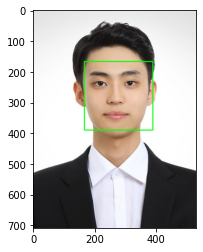

In [5]:
'''
찾은 얼굴 영역 박스 리스트가 얼굴에 잘 놓여있나 확인을 한다.
'''

# 박스의 범위(top_left, bottom_right)
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    # 얼굴영역을 지정하여 초록색 사각형을 박스범위에 그려준다.
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

# 사진 출력
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [6]:
'''
landmark model를 사용하여 얼굴에 landmark들을 표시하고 landmark list로 만들어놓는다.
'''

#  landmark 모델을 불러옵니다.
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# 얼굴의 landmark list들
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# landmark model 확인 얼굴이 하나밖에 없기에 가장 앞에있을 0번째 landmark를 확인한다.
print(len(list_landmarks[0]))

68


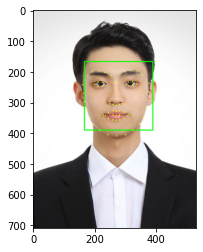

In [7]:
'''
landmark에 노란색 원을 찍어본다.
'''
for landmark in list_landmarks:
    for point in landmark:
        # landmark마다 노란색 원을 찍어본다.
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

# 사진 출력
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 03. 스티커 적용 위치 확인하기

In [8]:
'''
landmark중 코와 인중사이에 있는 33번째 landmark를 선택하여 위치를 정해줄 것이다.
'''

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):

    x = landmark[33][0]
    y = landmark[33][1]
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))


(x,y) : (271,309)
(w,h) : (224,224)


(224, 224, 3)


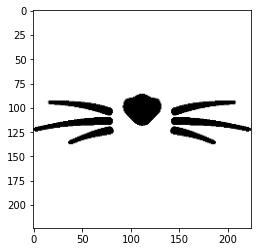

In [9]:
'''
sticker image를 load 한 후 얼굴 크기에 맞게 resize 시켜준다.
'''

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
plt.imshow(img_sticker)
print (img_sticker.shape)

In [10]:
'''
코가 중앙에 올 수 있도록 움직이고 초과 범위를 crop한다.
'''
# lefttop 이동
refined_x = x - w // 2
refined_y = y - h // 2

# 범위 넘어서는 곳 자르기
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0


print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (159,197)


## 04. 스티커 적용하기

In [11]:
'''
sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지.

스티커 이미지에서 사용할 부분은 255 이 아닌 색이 있는 부분을 사용합니다. 
따라서 np.where를 통해 img_sticker 가 255 인 부분은 sticker_area를 사용하고 255이 아닌 부분을 img_sticker를 사용. 

img_show에 적용한다. 
'''
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

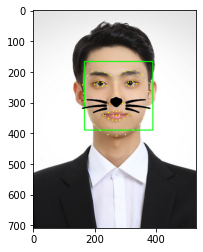

In [12]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

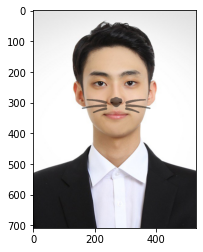

In [13]:
'''
addWeighted 함수를 적용하여 sticker를 반투명 상태로 만든다.
아무것도 그려지지 않은 img_bgr에서 실습을 진행한다.

'''

sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

# addd weight 조정하여 투명도 조절 
add = cv2.addWeighted(sticker_area, 0.5, img_sticker, 0.3, 0)

img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,add).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 05. 문제점 찾아보기

다양한 문제점을 시도해보기위하여 전과정을 함수화 시켰다. 위의 노드 과정과 다른점은 한 사진에 여러 얼굴이 잡혔을 때 얼굴마다 sticker를 붙혀주는 과정을 추가했다.

try except 구문을 활용하여 얼굴을 인식하지 못했을 때 "it's not face"를 출력해주도록 하였다.

In [14]:
def sticker_app(picture_name, background = 255):
    my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/' + picture_name
    img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
    img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
    
    plt.figure(figsize=(15, 5)) 
    plt.subplot(131)
    plt.title('Before')
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)

    # detector를 선언합니다
    detector_hog = dlib.get_frontal_face_detector()

    # detector_hog를 이용해서 얼굴의 bounding box를 추출
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

    #  landmark 모델을 불러옵니다.
    model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)
    
        
    # 얼굴 영역 박스 마다 face landmark를 찾아냅니다. 찾은 face landmark마다 sticker를 붙혀줍니다.
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        # face landmark 좌표를 저장해둡니다
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    # landmark 받았는지 확인
    try:
        if len(list_landmarks) <1:
            # 에러발생
            raise Exception("No No it's not face") 
    # 에러 발생 시 print문
    except Exception as e:
        print(e)
        
    # 에러 발생 안나면 진행
    else:
        for landmark in list_landmarks:
            for point in landmark:
                cv2.circle(img_show, point, 2, (0, 255, 255), -1)

        plt.subplot(132)
        plt.title('Computing')
        plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))

        for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
            x = landmark[33][0]
            y = landmark[33][1]
            w = h = dlib_rect.width()

            sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
            img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
            img_sticker = cv2.resize(img_sticker, (w,h))
            refined_x = x - w // 2
            refined_y = y - h // 2

            if refined_x < 0: 
                img_sticker = img_sticker[:, -refined_x:]
                refined_x = 0
            if refined_y < 0:
                img_sticker = img_sticker[-refined_y:, :]
                refined_y = 0

            # 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
            sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
            img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
                np.where(img_sticker== background,sticker_area,img_sticker).astype(np.uint8)

        
        plt.subplot(133)
        plt.title('After')
        plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
        plt.show()
    
    

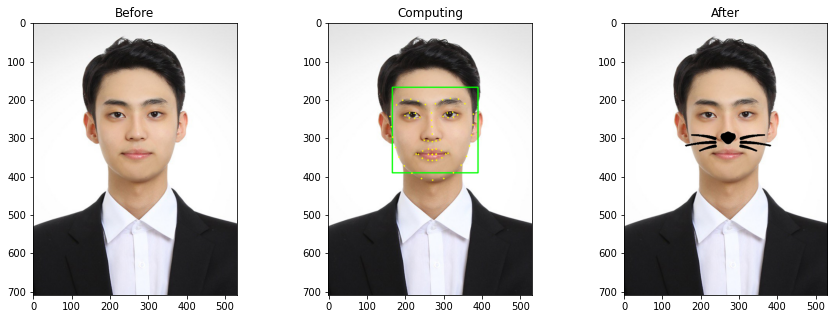

In [15]:
sticker_app('front.png')

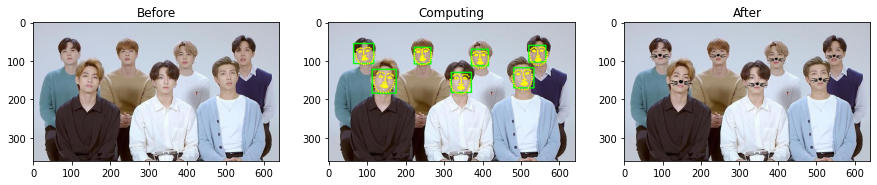

In [16]:
sticker_app('bts.jpg')

함수에 사진 파일 이름을 넘겨주어 Before After로 Sticker 적용 전후의 사진을 보여준다.
함수에 여러 인물에게 sticker를 붙혀주는 것 또한 작동이 된다.

### 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?

No No it's not face


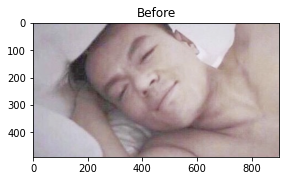

In [17]:
sticker_app('jyp.png')

누워있는 사진 중에서 유명한 사진을 넣어보았다. 얼굴로 인식을 못했다. 사진이 깔끔하지 못해서 그런것인가..? 깔끔한 사진을 넣어보아야겠다.

No No it's not face


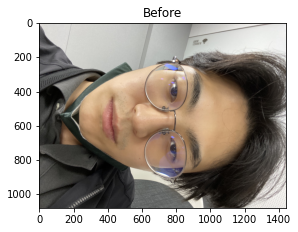

In [18]:
sticker_app('side.jpeg')

직접 사진을 찍어보았다. 아직도 인식을 하지못했다. 더 깔끔한 사진이 필요한 것인가..?

No No it's not face


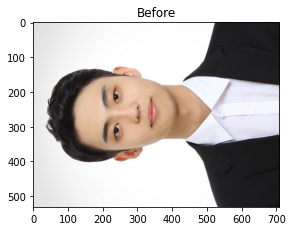

In [19]:
sticker_app('side_front.jpeg')

더 깔끔한 사진을 넣어도 인식하지못했다. 옆으로 된 사진을 인식하지 못한다.

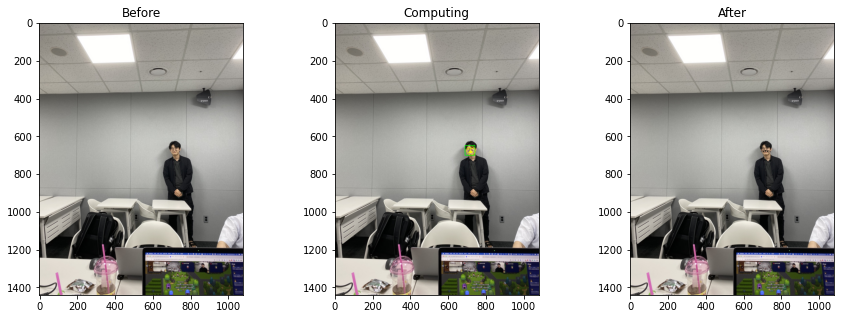

In [20]:
sticker_app('faraway.jpeg')

멀리에 있는 얼굴도 인식을 한다. 하지만 확대해서 확인하여보면 눈코입을 잘 구분하지 못하여 애매한 곳에 위치하고 있는 것을 확인할 수 있다.

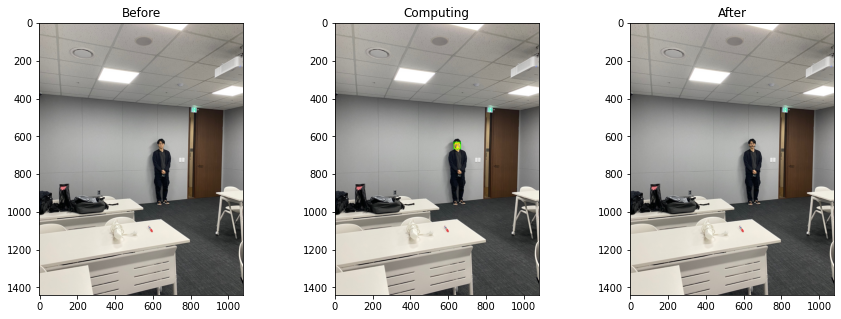

In [21]:
sticker_app('farfaraway.jpeg')

거리가 더 멀어져도 인식은 하지만 눈코입 인식이 불안하였다. 불안한 인식으로 정확한 위치에 스티커가 존재하지 않는다.

### 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?

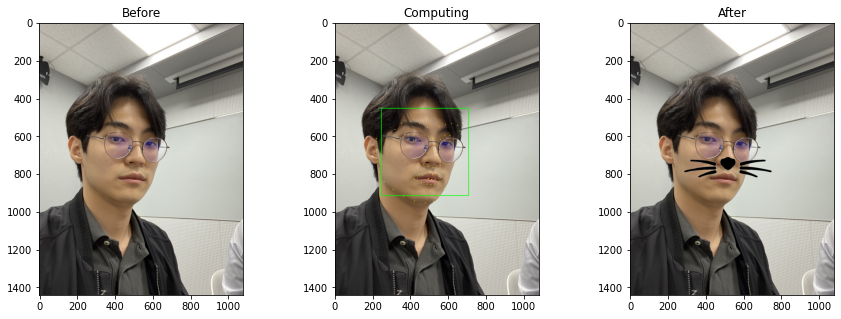

In [22]:
sticker_app('rotation.jpeg')

나름 돌아간 얼굴도 코를 잘 찾아서 스티커를 붙혀준다. 하지만 스티커가 얼굴과 함께 돌아가지는 않는다.

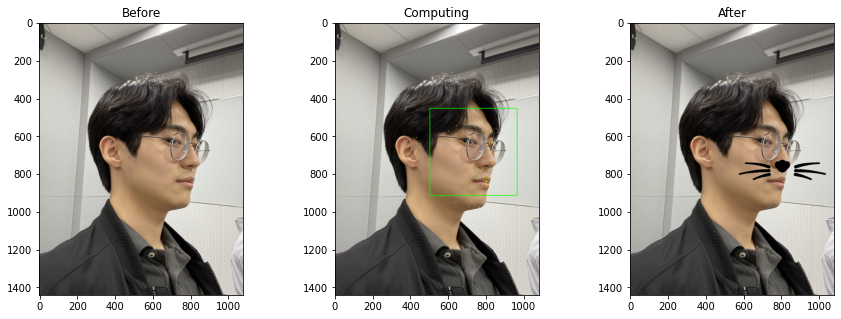

In [23]:
sticker_app('rotationrotaion.jpeg')

더돌려서 반만 나오게 해보자.. 그래도 코를 용케 찾아낸다. 하지만 여전히 스티커가 얼굴과 함께 돌아가지는 않는다.

No No it's not face


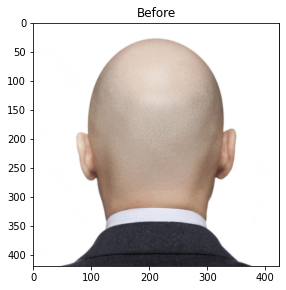

In [24]:
sticker_app('back.png')

완전히 뒤돌아봤다.. 역시 이것까지는 인식하지 못한다

### 스티커앱을 만들 때 정확도가 얼마나 중요할까요?

No No it's not face


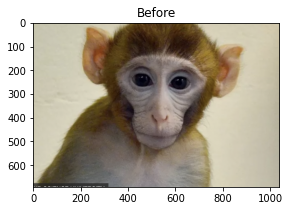

In [25]:
sticker_app('monkey.png')

인간과 닮은 동물도 한번 넣어봤다. 원숭이는 인식하지 못한다.

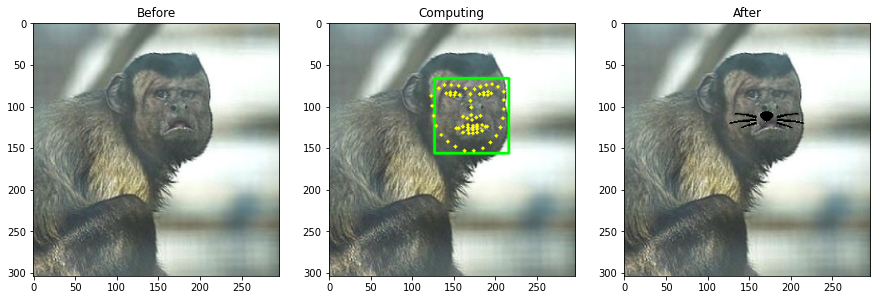

In [26]:
sticker_app('humonkey.png')

최근 인터넷에서 화제인 인간과 닮은 원숭이를 넣어봤다. 이 사진은 정확한 코의 위치는 아니지만 얼추 비슷하게 인식해냈다.

No No it's not face


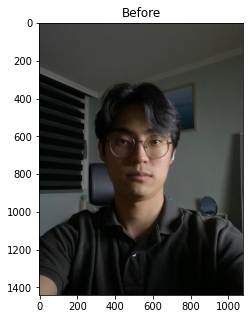

In [27]:
sticker_app('dark.jpeg')

늦게까지 프로젝트를 진행하다보니 하루가 다지났다. 명암도 끼칠까..? 명암을 낮게하니 얼굴로 인식을 하지 못했다. 명암도 얼굴인식에 중요한 요소이다.

## 06. 회고

> - sticker png 배경제거
    - node에서는 sticker의 배경을 제거하기위해서 0인 값을 지워줬었는데 고양이 수염은 거꾸로 배경만 살았다. 오히려 최대치인 255인 값을 바꿔주니까 되었다. png file 배경이 잘 안된다면 2개 모두를 시도해봐야겠다.
> - img_show, img_bgr 변수 이름 구분
    - img_show, img_bgr 변수를 구분하지 못하여 계속 똑같은 img에다가 스티커를 붙히고 있었다. 같은 이미지에 스티커를 붙히니까 투명도가 적용된 스티커를 확인하기가 어려웠다.
    - 왜 원본 data를 만드는 것이 중요한지 알 수 있는 시간이었다.
> - opencv 파일 특성
    - (세로,가로,색)으로 읽는 것이 익숙하지가 않았다. 대부분 (가로,세로,색)으로 생각할텐데 가로세로 부분이 바뀌어 있어서 사진의 위치를 계산해줄 때 힘들었다.
    - rgb 값이 아니라 bgr 방식으로 되어있어서 신경써주지 않으면 같은 실수를 반복했다. opencv 파일 특성을 이번기회에 제대로 알 수 있는 시간이 었다.
    - 또한 topleft가 0 부터 시작한다. y를 위로 올려줄 때 마이너스 연산을 하여 햇갈렸는데 자세히 보니 top left가 (0,0)이다.
> - 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
    - 옆으로 누웠을 때는 얼굴로 인식을 하지 못했다. 누워있을 때는 rotation을 시켜줘서 인식을 시키던지 해야한다.
    - 멀리서 인식을 했을 때 어느정도 얼굴은 알아보지만 눈코입을 정한 픽셀이 작아서 정확한 위치에 sticker를 위치시켜주지는 못한다.
> - 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
    - 얼굴 각도에 따라 얼굴 인식은 어느정도 하였지만 얼굴 각도에 맞게 스티커 또한 회전 시켜주지는 못했다. sticker 또한 얼굴에 맞게 회전을 시켜줘야 자연스러운 sticker가 될 수 있다.
> - 스티커앱을 만들 때 정확도가 얼마나 중요할까요?
    - 정확도가 중요하다. sticker가 사람이 아닌 원숭이를 사람 얼굴로 해석할 때가 있었다. 그리고 명암에 따라서 사람의 얼굴 방향에 따라서 인식하지 못했다. sticker app은 정해진 환경 즉 증명사진 찍듯이 사용하는 것이 아니니 정확도를 높이는 것이 중요하다.
    - 얼굴인식을 machine learning과 접목하여 특정 사람을 알아보게 학습시키면 핸드폰 잠금에 사용되는 얼굴인증도 어느정도 구현할 수 있지 않을까 싶었다.
> - 실행 속도가 중요할까요?
    - 실행 속도 중요하다. 지금은 사진으로만 사용했지만 대다수의 sticker app은 실시간으로 동영상과 함께 사용된다. 움직이는 물체를 인식하고 sticker을 반영해주려면 빠른 실행 속도가 필요하다.

## 07. 참고

- [예외 발생](https://dojang.io/mod/page/view.php?id=2400)
- [opencv file 특성](https://notstop.co.kr/1233/)
- [add_weighted 활용법](http://www.gisdeveloper.co.kr/?p=6407)